In [ ]:
# Import of project libraries
import numpy as np
import pandas as pd
import math
import sklearn
import sklearn.preprocessing
import datetime
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.preprocessing import PowerTransformer, QuantileTransformer
import seaborn as sns
from keras.models import Sequential,model_from_json
from keras.layers import Dense, LSTM
import os
from sklearn.model_selection import GridSearchCV
import pickle

from statsmodels.graphics.api import qqplot
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# DataProccessor class to handle transformations and visualizations

class DataProccessor:
  def __init__(self, df):
    self.df = df
  def visualize_features(self, features):
    '''function to plot given features vs date'''
    for k, v in features.items():
      plt.plot(self.df['Date'],self.df[k],color=v)

  def normalize_data(self, features):
    '''function to normalize given features using MinMaxScaler'''
    min_max_scaler = sklearn.preprocessing.MinMaxScaler()
    for feature in features:
      self.df[feature] = min_max_scaler.fit_transform(df[feature].values.reshape(-1,1))

  def plot_histograms(self, features):
    '''function to plot histograms'''
    fig, axes = plt.subplots(1, len(features), figsize=(15, 5))
    for i, column in enumerate(features):
      self.df[column].plot(kind='hist', bins=10, ax=axes[i])
      axes[i].set_title(column)
      axes[i].set_xlabel('Value')
      axes[i].set_ylabel('Frequency')

  def test_transformers(self, features):
    '''apply quantile transformation and generates graphs'''
    df_sqew = pd.DataFrame() # Creating Empty Dataframe
    qt = QuantileTransformer(n_quantiles=500, output_distribution='normal')
    j = 1
    fig = plt.figure(figsize=(20,30))
    for i in features:
        array = np.array(self.df[i]).reshape(-1, 1)
        y = qt.fit_transform(array)
        col = [i]
        col_1 = i
        y = pd.DataFrame(y,columns = col)
        df_sqew.insert(0,col_1,y)
        plt.subplot(4,2,j)
        sns.histplot(array, bins = 50, kde = True)
        plt.title(f"Original Distribution for {i}")
        plt.subplot(4,2,j+1)
        sns.histplot(y, bins = 50, kde = True)
        plt.title(f"Quantile Transform for {i}")
        j += 2
    return df_sqew, qt


In [ ]:
#Load the data from CSV
df = pd.read_csv("/content/drive/MyDrive/Python/F.csv")
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,1972-06-01,0.000000,2.173495,2.149165,2.153220,0.277406,1091238
1,1972-06-02,2.153220,2.173495,2.141055,2.149165,0.276884,1174468
2,1972-06-05,2.149165,2.169440,2.141055,2.149165,0.276884,5209582
3,1972-06-06,2.149165,2.157275,2.116725,2.124835,0.273750,1424158
4,1972-06-07,2.124835,2.137000,2.112670,2.112670,0.272182,675088
...,...,...,...,...,...,...,...
12433,2021-09-20,13.070000,13.190000,12.630000,12.820000,12.820000,126152200
12434,2021-09-21,12.890000,12.970000,12.660000,12.770000,12.770000,60473100
12435,2021-09-22,12.920000,13.390000,12.910000,13.230000,13.230000,75784000
12436,2021-09-23,13.350000,13.740000,13.320000,13.710000,13.710000,68708100


In [ ]:
# Review data info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12438 entries, 0 to 12437
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       12438 non-null  object 
 1   Open       12438 non-null  float64
 2   High       12438 non-null  float64
 3   Low        12438 non-null  float64
 4   Close      12438 non-null  float64
 5   Adj Close  12438 non-null  float64
 6   Volume     12438 non-null  int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 680.3+ KB


In [ ]:
#Checking null values
df.isna().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

The data does not present null values

In [ ]:
# Review initial descriptive statistics
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,12438.000000,12438.000000,12438.000000,12438.000000,12438.000000,1.243800e+04
mean,9.265754,9.382567,9.138992,9.259339,5.359546,2.129446e+07
std,7.061066,7.160028,6.962678,7.057937,4.558708,2.996994e+07
min,0.000000,0.648804,0.638667,0.643736,0.141868,2.990110e+05
25%,2.585080,2.615493,2.540728,2.577477,0.695269,4.309499e+06
50%,8.839347,8.940000,8.738025,8.838694,4.713356,8.743347e+06
75%,12.450000,12.570000,12.300000,12.430000,8.973226,2.903842e+07
max,36.819485,37.300335,35.720394,36.647751,18.928154,5.411756e+08


In [ ]:
# Transform date to datetime
df['Date'] = pd.to_datetime(df['Date'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12438 entries, 0 to 12437
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       12438 non-null  datetime64[ns]
 1   Open       12438 non-null  float64       
 2   High       12438 non-null  float64       
 3   Low        12438 non-null  float64       
 4   Close      12438 non-null  float64       
 5   Adj Close  12438 non-null  float64       
 6   Volume     12438 non-null  int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 680.3 KB


In [ ]:
# Instantiate a new data processor
data_processor = DataProccessor(df)

In [ ]:
price_features = {'Open':'red',
                    'Close':'green',
                    'Low': 'blue',
                    'High': 'black'}

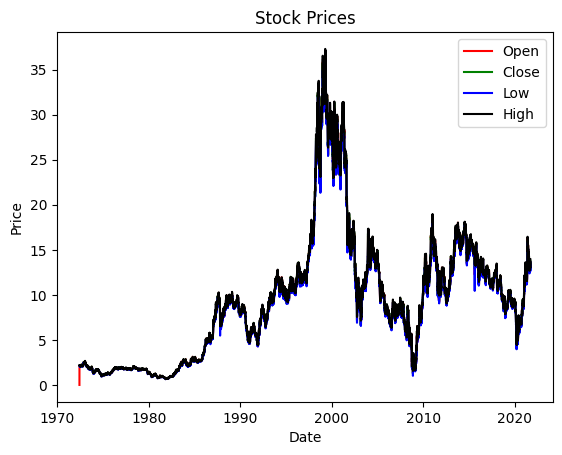

In [ ]:
# Visualize plots of price features vs time

data_processor.visualize_features(price_features)
plt.title('Stock Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend(price_features.keys())

* The **Open, Close, Low, High** prices overlap because the fluctuation is small for a trading section.
* The stock price had a peak around the years of 2000 reaching values higher than 35 but it fell to fluctuate around 10 for the years after 2005.





Text(0, 0.5, 'Volume')

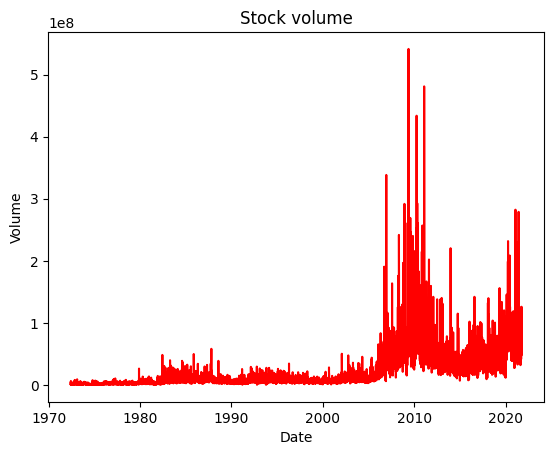

In [ ]:
data_processor.visualize_features({'Volume':'red'})
plt.title('Stock volume')
plt.xlabel('Date')
plt.ylabel('Volume')

* Before the year 2005, the volume (number of units traded in a day) had remained low. However, after said date, it increased to a peak of 5.6e8 in 2010 and it remained fluctuating around 1e8 in the following years.

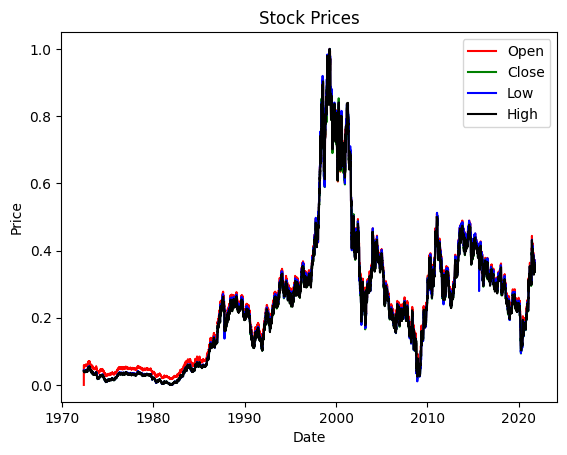

In [ ]:
#plot after normalizing the data
data_processor.visualize_features(price_features)
plt.title('Stock Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend(price_features.keys())

In [ ]:
# checking how the data looks after normalization
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,1972-06-01,0.000000,0.041600,0.043057,0.041925,0.277406,1091238
1,1972-06-02,0.058480,0.041600,0.042825,0.041813,0.276884,1174468
2,1972-06-05,0.058370,0.041489,0.042825,0.041813,0.276884,5209582
3,1972-06-06,0.058370,0.041157,0.042132,0.041137,0.273750,1424158
4,1972-06-07,0.057710,0.040604,0.042016,0.040799,0.272182,675088
...,...,...,...,...,...,...,...
12433,2021-09-20,0.354975,0.342174,0.341811,0.338192,12.820000,126152200
12434,2021-09-21,0.350086,0.336171,0.342667,0.336803,12.770000,60473100
12435,2021-09-22,0.350901,0.347631,0.349793,0.349579,13.230000,75784000
12436,2021-09-23,0.362580,0.357180,0.361480,0.362911,13.710000,68708100


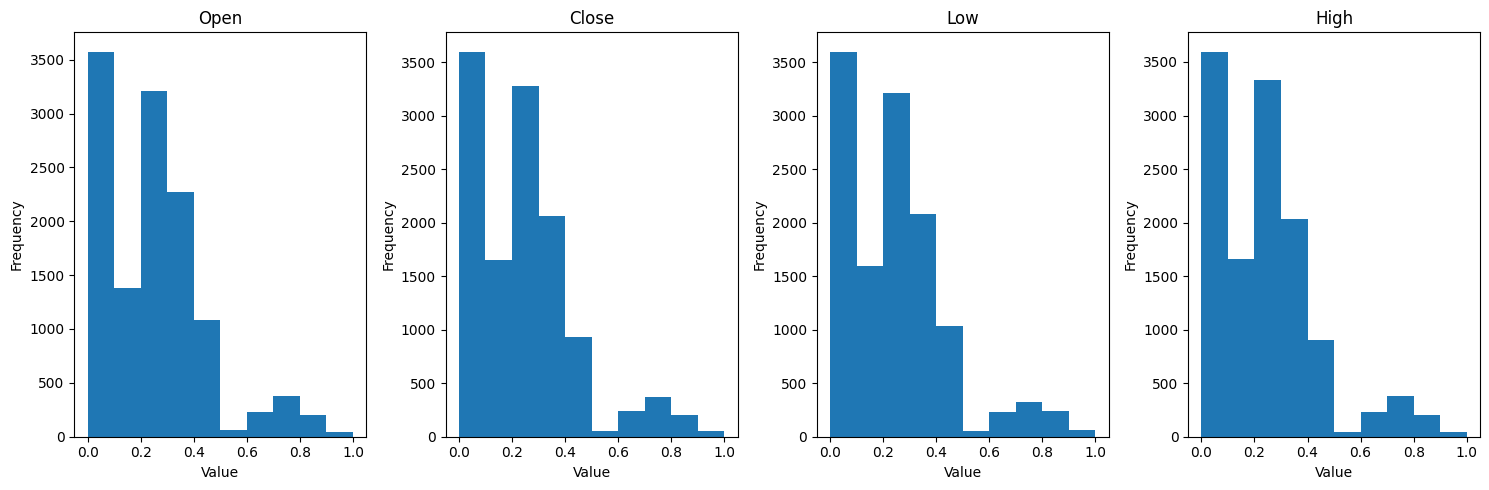

In [ ]:
#checking skewness of Open, Close, Low, High Columns
data_processor.plot_histograms(price_features.keys())
plt.tight_layout()
plt.show()

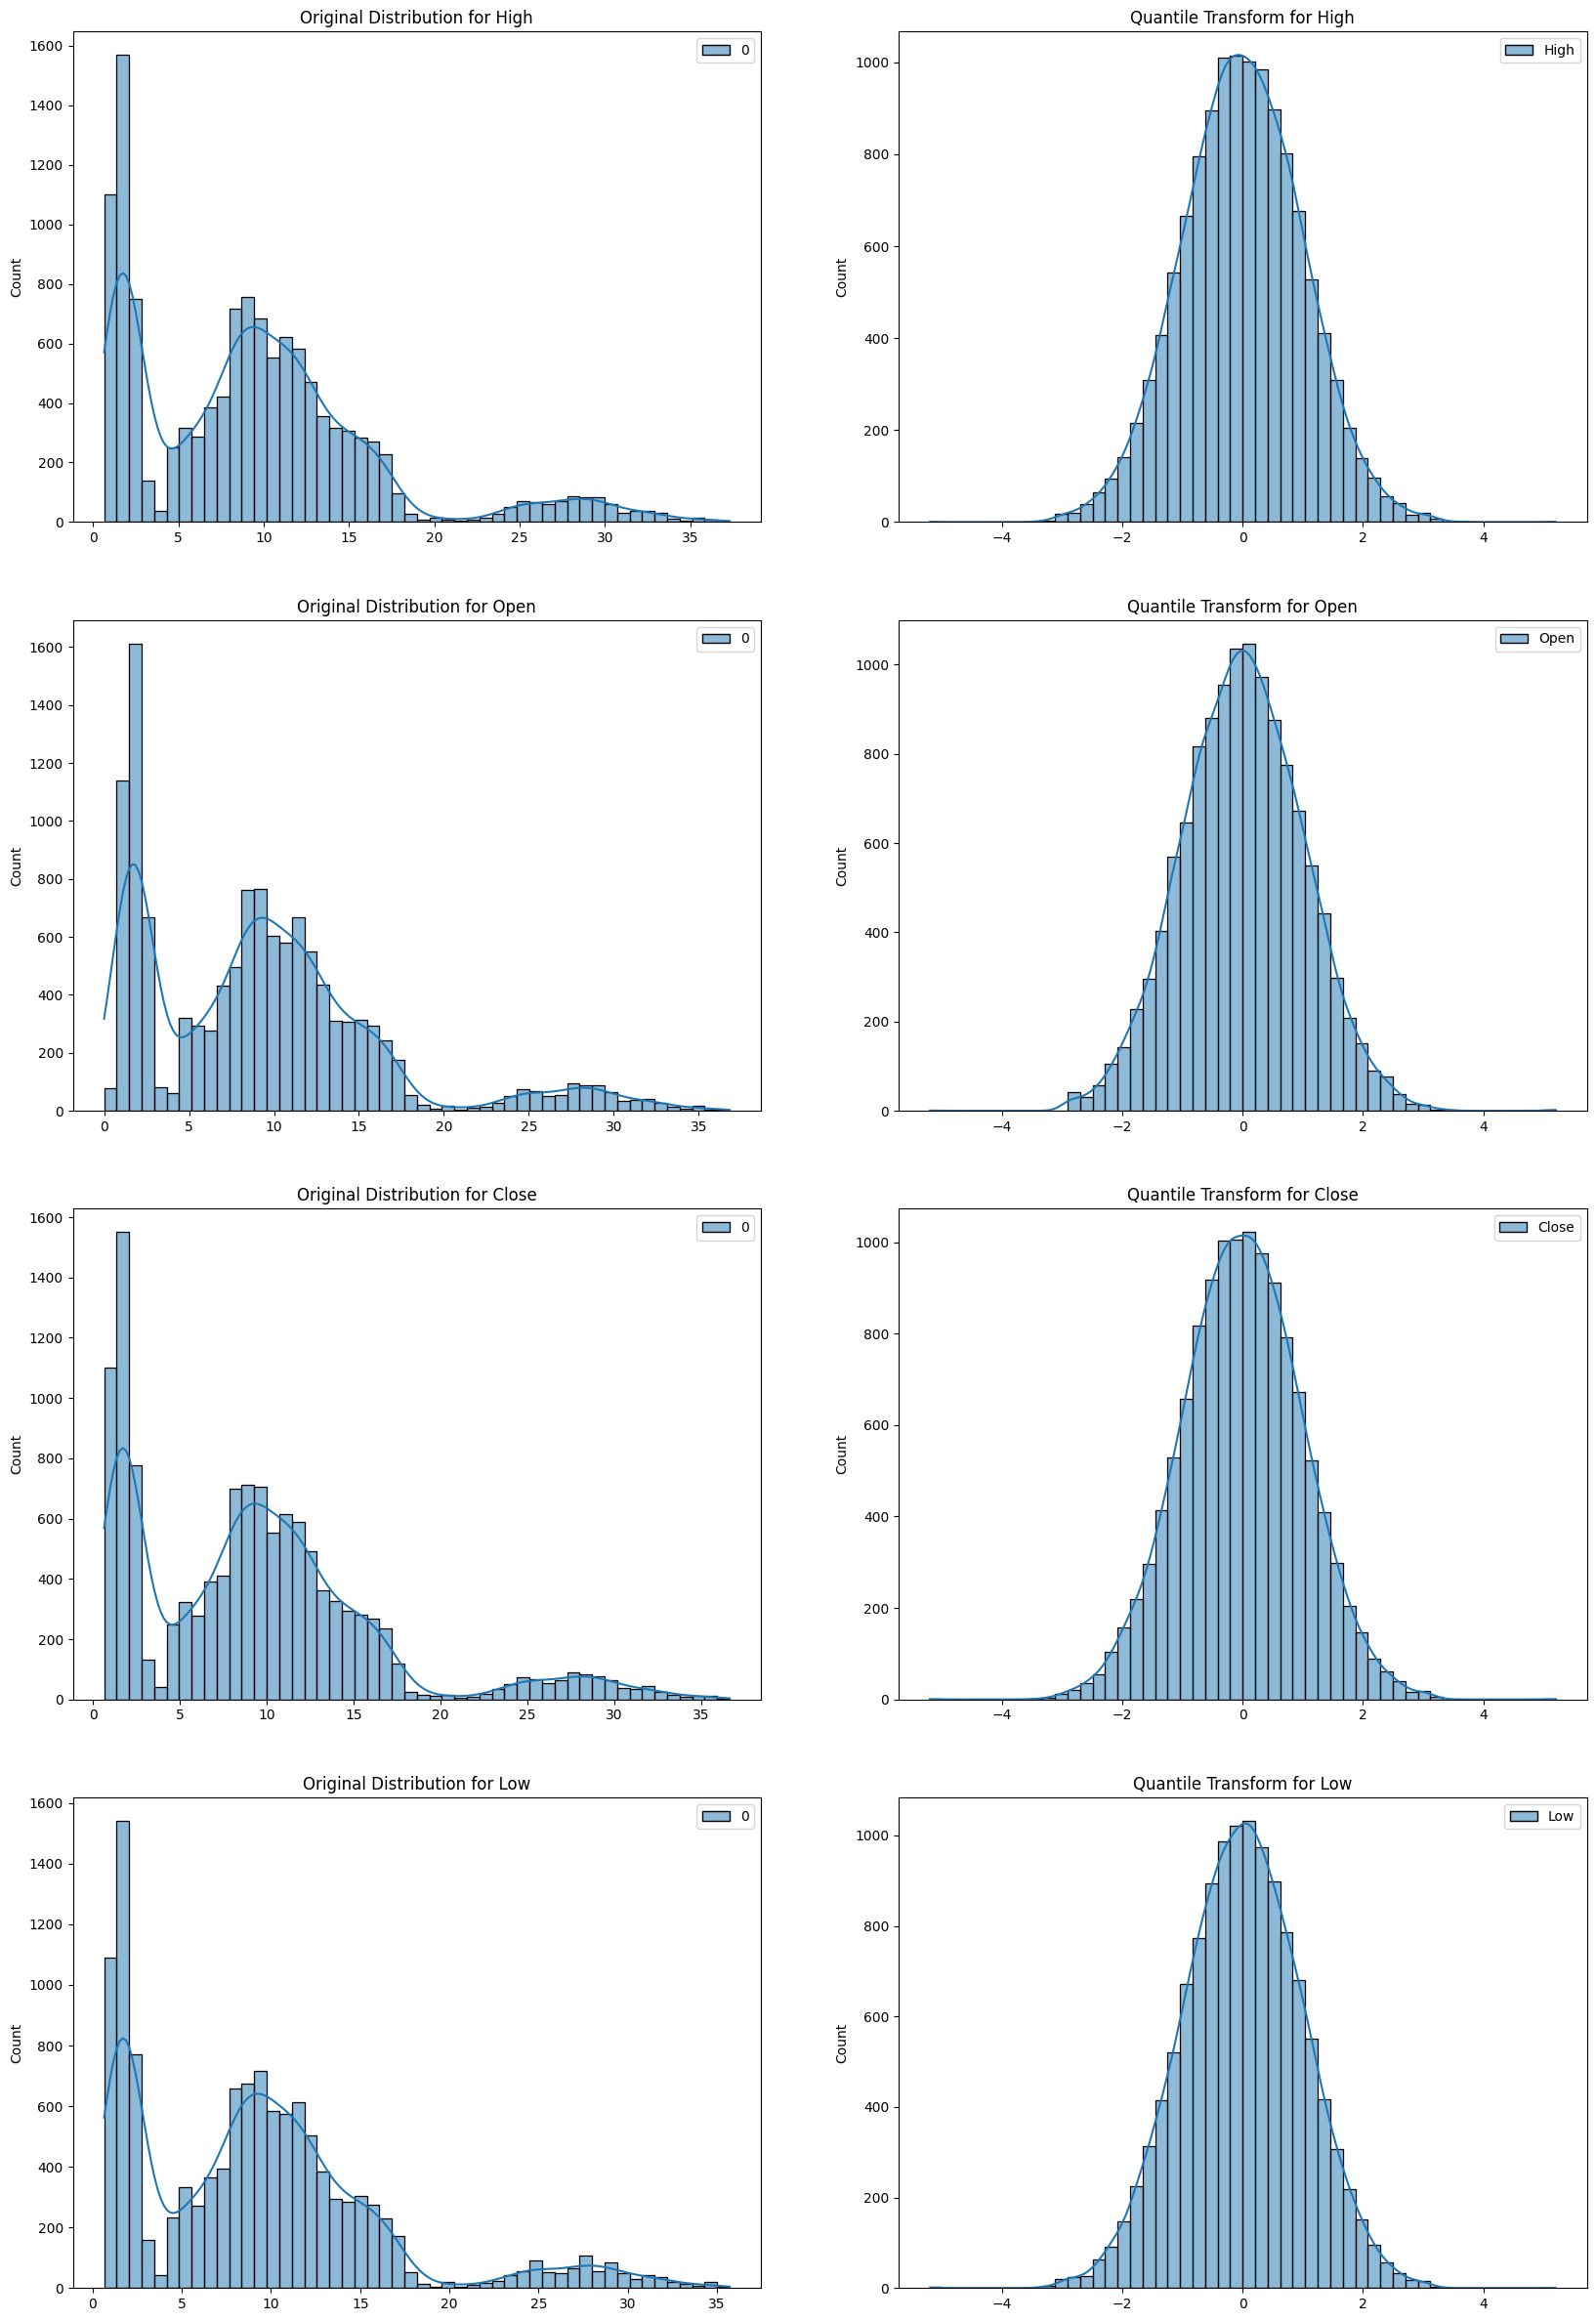

In [ ]:
# Checking transformers
cols = ['High','Open','Close','Low']
df_sqew, qt = data_processor.test_transformers(cols)

In [ ]:
df_sqew

,Low,Close,Open,High
0,-0.748708,-0.764058,-5.199338,-0.765799
1,-0.752017,-0.765757,-0.763430,-0.765799
2,-0.752017,-0.765757,-0.765725,-0.767299
3,-0.765545,-0.778716,-0.765725,-0.772090
4,-0.767509,-0.782420,-0.777732,-0.782280
...,...,...,...,...
12433,0.740916,0.730753,0.784297,0.770705
12434,0.745701,0.723705,0.758370,0.739057
12435,0.782022,0.792866,0.761722,0.801616
12436,0.841356,0.847362,0.830051,0.842576


In [ ]:
data = df_sqew.filter(['Close'])
# Convert the dataframe to a numpy array
df_pred = data.values

In [ ]:
df_close = df.filter(['Close'])
df_close = df_close.values

In [ ]:
# Create the training data set
# Create the scaled training data set
train_data = df_pred[0:10000, :]
# Split the data into x_train and y_train data sets
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
    if i<= 61:
        print(x_train)
        print(y_train)
        print()

# Convert the x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_train.shape

[array([-0.7640583 , -0.76575683, -0.76575683, -0.77871568, -0.78242026,
       -0.78964792, -0.79483165, -0.79483165, -0.78749078, -0.77424209,
       -0.77871568, -0.77424209, -0.77994935, -0.77748319, -0.7836575 ,
       -0.78964792, -0.79163561, -0.79483165, -0.78749078, -0.78964792,
       -0.79323262, -0.79902263, -0.80099858, -0.80396837, -0.79803583,
       -0.80001021, -0.80606746, -0.80939683, -0.81435159, -0.81435159,
       -0.81575886, -0.81575886, -0.80939683, -0.80606746, -0.81435159,
       -0.80606746, -0.78749078, -0.79163561, -0.79483165, -0.79803583,
       -0.78964792, -0.78964792, -0.78964792, -0.77871568, -0.75952914,
       -0.75620079, -0.75514857, -0.75725385, -0.77424209, -0.77100909,
       -0.7640583 , -0.75725385, -0.76575683, -0.79163561, -0.77748319,
       -0.77748319, -0.77100909, -0.75620079, -0.73794515, -0.74358508])]
[-0.7499756929954421]

[array([-0.7640583 , -0.76575683, -0.76575683, -0.77871568, -0.78242026,
       -0.78964792, -0.79483165, -0.7

(9940, 60, 1)

In [ ]:
# Create the testing data set
# Create a new array containing scaled values from index 1543 to 2002
test_data = df_pred[10000 - 60: , :]
# Create the data sets x_test and y_test
x_test = []
y_test = df_close[10000:, :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])

# Convert the data to a numpy array
x_test = np.array(x_test)

# Reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

# Model without Hyperparameter Tunning

In [ ]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape= (x_train.shape[1], 1)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(x_train, y_train, batch_size=1, epochs=1)
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")

9940/9940 [==============================] - 87s 8ms/step - loss: 0.0127


In [ ]:
# Get the models predicted price values for test data

predictions = model.predict(x_test)
#predictions = scaler.inverse_transform(predictions)
predictions = qt.inverse_transform(predictions)
# Get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
print(f'The rmse result was: {rmse}')

77/77 [==============================] - 1s 6ms/step
The rmse result was: 0.3151187485104487


**RMSE** is a common metric for regression problems. It was used in this case as it gives us an idea of the difference between real values and predicted values, as higher the value as lower is the ability of the model to predict correctly on new data. Additionally, we used this metric instead of MSE as the first one has the same units as the target variable (Close) which makes easier the results interpretation.

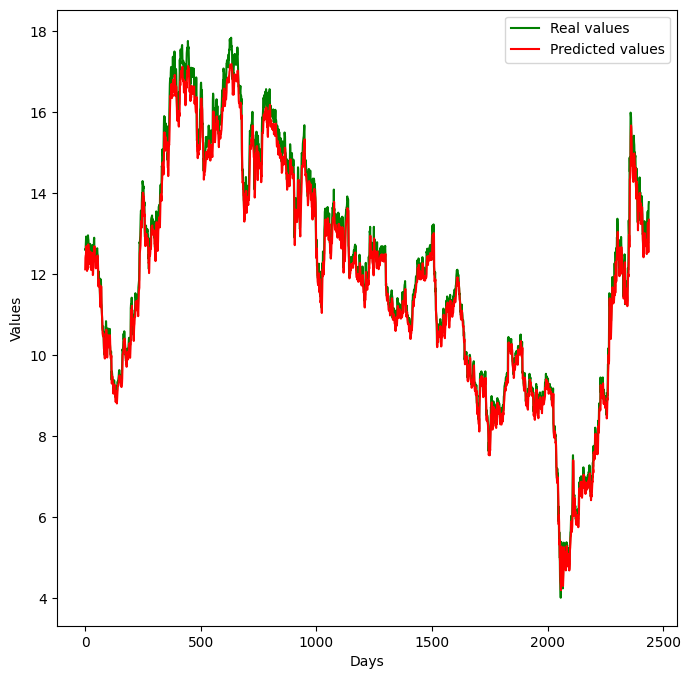

In [ ]:
# results plot
plt.figure(figsize=(8,8))
plt.plot(y_test,color="green",label="Real values")
plt.plot(predictions,color="red",label="Predicted values")
plt.legend()
plt.xlabel("Days")
plt.ylabel("Values")
plt.show()

The **RMSE** was satisfactory low considering the scale of the data. For instance, the '**Close**' mean for this set of data is 9.26 which means that a rmse of 0.32 is low. This can be seen in the graph above, where the predicted values (red line) remain close to the real values (green line).

# Model with Hyperparameter Tunning

In [ ]:
#Function to save the trained model
def save_model_pickle(file_name, model):
  file_name = file_name + '.pkl'
  with open(file_name, 'wb') as file:
      pickle.dump(model, file)

#Function to retrieve the trained model
def retrieve_model_pickle(file_name):
  file_name = file_name + '.pkl'
  with open(file_name, 'rb') as file:
    model = pickle.load(file)
    return model

In [ ]:
# Use of GridSearch to do hyperparameter tunning

param_grid = {
    'learning_rate': [0.001, 0.01, 0.1],
    'batch_size': [16, 32],
    'epochs': [10, 20]
}

def build_model(learning_rate):
    model = Sequential()
    model.add(LSTM(128, return_sequences=True, input_shape=(x_train.shape[1], 1)))
    model.add(LSTM(64, return_sequences=False))
    model.add(Dense(25))
    model.add(Dense(1))
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss='mean_squared_error')
    return model
model = tf.keras.wrappers.scikit_learn.KerasRegressor(build_model)
grid_search = GridSearchCV(model, param_grid, cv=3)
grid_search.fit(x_train, y_train)

<ipython-input-17-311d9072f011>:17: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = tf.keras.wrappers.scikit_learn.KerasRegressor(build_model)


Epoch 1/10
415/415 [==============================] - 9s 8ms/step - loss: 0.0142
Epoch 2/10
415/415 [==============================] - 3s 8ms/step - loss: 0.0065
Epoch 3/10
415/415 [==============================] - 4s 10ms/step - loss: 0.0057
Epoch 4/10
415/415 [==============================] - 3s 8ms/step - loss: 0.0050
Epoch 5/10
415/415 [==============================] - 3s 8ms/step - loss: 0.0043
Epoch 6/10
415/415 [==============================] - 3s 8ms/step - loss: 0.0043
Epoch 7/10
415/415 [==============================] - 4s 10ms/step - loss: 0.0043
Epoch 8/10
415/415 [==============================] - 3s 8ms/step - loss: 0.0039
Epoch 9/10
415/415 [==============================] - 3s 8ms/step - loss: 0.0041
Epoch 10/10
208/208 [==============================] - 2s 5ms/step - loss: 0.0041
Epoch 1/10
415/415 [==============================] - 8s 8ms/step - loss: 0.0189
Epoch 2/10
415/415 [==============================] - 3s 8ms/step - loss: 0.0089
Epoch 3/10
415/415 [=====

GridSearchCV(cv=3,
             estimator=<keras.wrappers.scikit_learn.KerasRegressor object at 0x7ddce06d3100>,
             param_grid={'batch_size': [16, 32], 'epochs': [10, 20],
                         'learning_rate': [0.001, 0.01, 0.1]})

In [ ]:
best_params = grid_search.best_params_
best_estimator = grid_search.best_estimator_
best_neg_mse = grid_search.best_score_
best_mse = -best_neg_mse

print(f'The best params were: {best_params}')
print(f'The best rmse was: {np.sqrt(best_mse)}')

The best params were: {'batch_size': 16, 'epochs': 10, 'learning_rate': 0.001}
The best rmse was: 0.060317559549896274


In [ ]:
#Save trained model
save_model_pickle('LSTM2', best_estimator)

In [ ]:
# Get the models predicted price values for test data

predictions = best_estimator.predict(x_test)
predictions = predictions.reshape(-1, 1)
predictions = qt.inverse_transform(predictions)
# Get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
print(f'The rmse result was: {rmse}')

153/153 [==============================] - 1s 4ms/step
The rmse result was: 0.4019030395826733


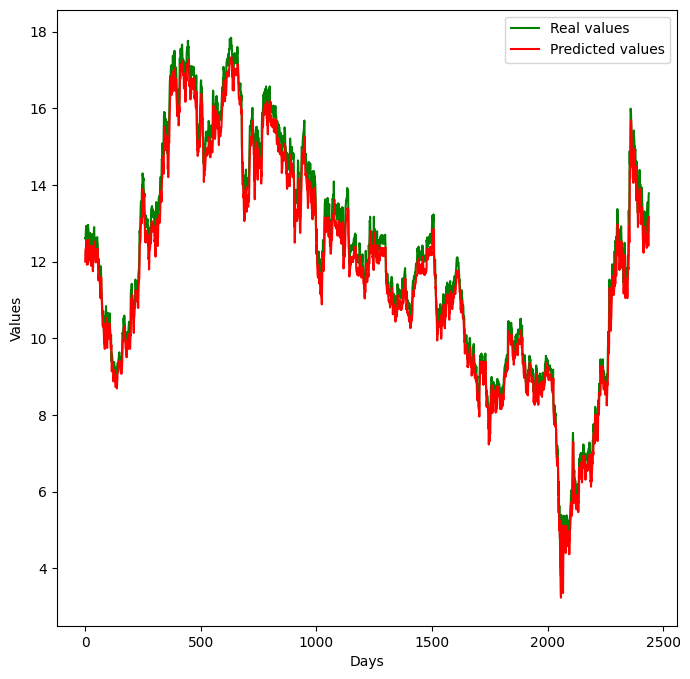

In [ ]:
# results plot
plt.figure(figsize=(8,8))
plt.plot(y_test,color="green",label="Real values")
plt.plot(predictions,color="red",label="Predicted values")
plt.legend()
plt.xlabel("Days")
plt.ylabel("Values")
plt.show()

* By comparing the RMSE for training data (0.06) vs testing data (0.4) we can conclude that the model is **overfiting**.

* The best hyperparameters were: batch_size = 16, epochs=10, learning_rate=0.001

* We were not able to improve the model performance with the technique and params used for hyperparameter tunning.

**Conclusions**

* LSTM (Long Short-Term Memory) was a powerful technique to predict stock prices for the present dataset. With a RMSE of 0.31 for testing data.

* However, the model is overfitting, as was seen by comparing the RMSE for the train data (0.06) vs. test data (0.4) during hyperparameter tunning.

* The technique and parameters used for hyperparameter tunning could not improve RMSE for testing data.

* Further work to improve the model should include regularization techniques to reduce overfitting.